# Lab 4: Gaussian Mixture Models
Welcome to DS102 lab! 

The goals of this lab are to further investigate the Gaussian mixture model and implement the EM algorithm. 

The code you need to write is commented out with a message "TODO: fill in". There is additional documentation for each part as you go along.

## Course Policies

**Collaboration Policy**:
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

**Submission**: to submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope (any other screenshotting or pdf printing method is acceptable as well).

**This assignment should be completed and submitted before Thursday, February 20, 2020 at 11:59 PM.** 

# Collaborators
Write names of your collaborators in this cell.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

## Read in Data
We begin by reading in a comma seperated file of heights similar to the data we used in lecture. The dataframe contains information about heights (in centimeters) and sex.

In [2]:
# Read in the csv of sex and heights.
dataframe = pd.read_csv("heights.csv")

# Save all heights in a numpy array.
all_heights = dataframe["Height"].to_numpy()

# Split the heights by sex.
is_male = (dataframe["Sex"] == "Male")
male_heights = all_heights[is_male]
female_heights = all_heights[is_male == False]

## 1) Statistics With Known Categories
First let's assume we know about the sex of the person associated with each height. Let's see what the two empirical height distributions look like first.

Text(0, 0.5, 'count of people')

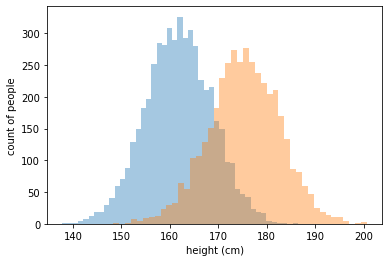

In [7]:
# Plot a histogram of female and male heights.
sns.distplot(female_heights, kde=False)
sns.distplot(male_heights, kde=False)
plt.xlabel("height (cm)")
plt.ylabel("count of people")

The plot seems to indicate that heights are normally distributed both for males and females which is in line with what we would expect. Now let's try to see what the mean $\left(\mu_0\right)$ and standard deviation $\left(\sigma_m\right)$ associated with male heights is, similarly we can find the mean $\left(\mu_f\right)$ and standard deviation $\left(\sigma_f\right)$ associated with female heights. We also want to get the proportion of males $\left(\pi_m\right)$ and females $\left(\pi_f\right)$ in the dataset.

In [4]:
# Find the mean of male heights and the standard deviation of male heights.
mu_m = np.mean(male_heights)# TODO: Fill this in.
sigma_m = np.std(male_heights)# TODO: Fill this in.

# Find the mean of female heights and the standard deviation of female heights.
mu_f = np.mean(female_heights)# TODO: Fill this in.
sigma_f = np.std(female_heights)# TODO: Fill this in.

# Find the number of males and females.
num_females = female_heights.shape[0]
num_males = male_heights.shape[0]
num_people = all_heights.shape[0]
pi_m = num_females / num_people# TODO: Fill this in.
pi_f = num_males / num_people# TODO: Fill this in.

# Print all the statistics.
print("---Male Statistics---")
print("pi_m={:.4f}, mu_m={:.2f}, sigma_m={:.2f}".format(pi_m, mu_m, sigma_m))
print("---Female Statistics---")
print("pi_f={:.4f}, mu_f={:.2f}, sigma_f={:.2f}".format(pi_f, mu_f, sigma_f))

---Male Statistics---
pi_m=0.5556, mu_m=175.37, sigma_m=7.29
---Female Statistics---
pi_f=0.4444, mu_f=161.82, sigma_f=6.85


## 2) Statistics With Unknown Categories
Now let's assume we don't know the sex of the person associated with each height. It still seems reasonable to assume that heights are normally distributed. Let's begin by finding the mean $\left(\mu_a\right)$ and standard deviations $\left(\sigma_a\right)$ across all heights.

In [5]:
# Find the mean and the standard deviation of all heights.
mu_a = np.mean(all_heights)# TODO: Fill this in.
sigma_a = np.std(all_heights)# TODO: Fill this in.

# Print the statistics across all heights.
print("---All Statistics---")
print("mu_a={:.2f}, sigma_a={:.2f}".format(mu_a, sigma_a))

---All Statistics---
mu_a=167.84, sigma_a=9.75


Now let's try to plot the histogram of all heights and compare it to a histogram of data that has actually been generated from the distribution $\mathcal{N}(\mu_a, \sigma_a)$.

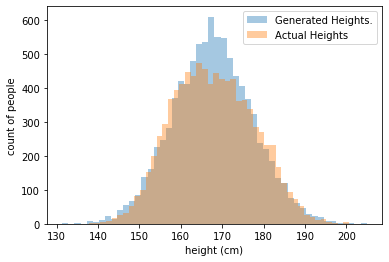

In [13]:
# Create random_state so any random operation always returns the same result.
random_state = np.random.RandomState(0)

# Generate some normally distributed random data with
# mean mu_a and standard deviation sigma_a.
num_people = all_heights.shape[0]
generated_heights = random_state.randn(num_people) * sigma_a + mu_a

# Plot the generated data.
sns.distplot(generated_heights, kde=False, label="Generated Heights.")
# Plot the real heights.
sns.distplot(all_heights, kde=False, label="Actual Heights")
# Add the legend and axis labels to the plot.
plt.xlabel("height (cm)")
plt.ylabel("count of people")
plt.legend()

The fit is relatively close but it seems we don't get the same peaking behavior around the mean. Let's see if we can do better. 

## 3) Gaussian Mixure Models (GMMs) and Expectation Maximization (EM)

In this next section, we're going to assume the data comes from a Gaussian Mixture Model (GMM) consisting of two Gaussian distributions and we will use expectation maximization to approximate the Gaussian and proportion parameters. We will call the approximated proportion parameters $\pi_0$ and $\pi_1$, the Gaussian parameters associated with the first Gaussian $\mu_0$ and $\sigma_0$, and the Gaussian parameters associated with the second Gaussian $\mu_1$ and $\sigma_1$. Let's begin by implementing an expectation maximization function.

### 3a) Complete the function below so we can get an estimate of $\mu_0$ and $\mu_1$ in the maximization part of the algorithm. 
Remember that our estimate of $\mu_k$ (where $k$ is the $k^{th}$ distribution) is given by
$$\mu_k = \frac{\sum_{i=1}^n x_i z_k(i)}{\sum_{i=1}^n z_k(i)}$$
where $z_k(i)$ is the estimate of the probability that datapoint $i$ belongs to the distribution $k$, $\mathbb{P}(K=k|x_i)$, that we obtained in the expectation part of the algorithm.

Note: The version of the expectation maximization algorithm we present here assumes we don't know any of the $\pi$s or $\mu$s. As in the lecture we assume we magically know the $\sigma$s. If you're interested in the derivation of the version where we don't know sigma either you can look at [this link](https://stephens999.github.io/fiveMinuteStats/intro_to_em.html#mle_of_gaussian_mixture_model) but the high level idea remains the same. Furthermore we've specialized the function for just a mixture of two Gaussian but this can be generalized to $K$ Gaussians for any value of $K$.

In [9]:
def gmm_expectation_maximization(data, pi_0, mu_0, pi_1, mu_1, num_steps):
    """ Perform expectation maximization assuming a Gaussian mixture model consisting of two Gaussians.
    
    Parameters
    ----------
    data : numpy array of shape n
        The matrix of datapoints we've observed.
    pi_0 : float
        Our initial estimate of pi_0.
    mu_0 : float
        Our initial estimate of mu_0.
    pi_1 : float
        Our initial estimate of pi_1.
    mu_1 : float
        Our initial estimate of mu_1.
    num_steps : int
        The number of times to run the expectation maximization.
    """
    for step in range(num_steps):
        # First run the expectation step.
        gaussian_prob_0 = (np.exp(-(data - mu_0) ** 2 / (2 * sigma_0)) /
                           (np.sqrt(2 * np.pi) * sigma_0))
        gaussian_prob_1 = (np.exp(-(data - mu_1) ** 2 / (2 * sigma_1)) /
                           (np.sqrt(2 * np.pi) * sigma_1))
        normalizing_factor = pi_0 * gaussian_prob_0 + pi_1 * gaussian_prob_1
        # z_k is the vector of estimated probabilities that each datapoint i
        # belongs to the distribution k. In other words the ith index is an
        # estimate of P(K=k|x_i).
        z_0 = pi_0 * gaussian_prob_0 / normalizing_factor
        z_1 = pi_1 * gaussian_prob_1 / normalizing_factor
        
        # Now run the maximization step.
        # N_k is the estimated number of points assigned to the distribution k.
        N_0 = np.sum(z_0)
        N_1 = np.sum(z_1)
        pi_0 = N_0 / data.shape[0]
        pi_1 = N_1 / data.shape[0]
        mu_0 = np.sum(data * z_0) / np.sum(z_0) # TODO: Fill this in.
        mu_1 = np.sum(data * z_1) / np.sum(z_1) # TODO: Fill this in.
        
    return pi_0, mu_0, sigma_0, pi_1, mu_1, sigma_1

Now that we've defined our expectation maximization function let's actually run it on our data. We'll want reasonable original estimates for our estimated parameters. As a very rough initial estimate let's pick:
* $\pi_0 = \pi_1 = 0.5$ since we have no reason to believe one of the Gaussians will be sampled more often than the other. Furthermore if one of the $\pi_k$ values was much larger than the other we'd expect to have our single Gaussian estimate above more closely match the generated data since it would be dominated by the Gaussian with the larger value of $\pi_k$.
* $\mu_0 = 150, \mu_1 = 185$ since it's reasonable for us to assume one distribution is has a larger mean than the other
* $\sigma_0 = 6.848, \sigma_1 = 7.295$ these are the true values of $sigma$ as stated above.

In [11]:
sigma_0 = 6.848
sigma_1 = 7.295
# TODO: Fill in the parameters below with the values specified in the above cell.
pi_0, mu_0, sigma_0, pi_1, mu_1, sigma_1 = gmm_expectation_maximization(data=all_heights,
                                                                        pi_0=0.5,# TODO: Fill this in.
                                                                        mu_0=150,# TODO: Fill this in.
                                                                        pi_1=0.5,# TODO: Fill this in.
                                                                        mu_1=185,# TODO: Fill this in.
                                                                        num_steps=100)
# Print the estimated parameters for both distributions.
print("---Distribution 0 Estimated Parameters---")
print("pi_0={:.4f}, mu_0={:.2f}, sigma_0={:.2f}".format(pi_0, mu_0, sigma_0))
print("---Distribution 1 Estimated Parameters---")
print("pi_1={:.4f}, mu_1={:.2f}, sigma_1={:.2f}".format(pi_1, mu_1, sigma_1))

---Distribution 0 Estimated Parameters---
pi_0=0.5268, mu_0=160.26, sigma_0=6.85
---Distribution 1 Estimated Parameters---
pi_1=0.4732, mu_1=176.28, sigma_1=7.29


Finally let's see how closely our real data matches data generated from data randomly generated from the GMM whose parameters we just estimated.

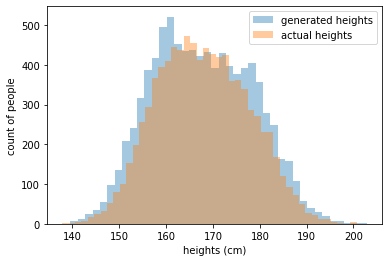

In [12]:
# Create random_state so any random operation always returns the same result.
random_state = np.random.RandomState(0)

# Generate some data using the GMM parameters we just estimated above.
num_people = all_heights.shape[0]
# First let's create an array of bernouilli samples with probability of success pi_1.
dist_number = random_state.binomial(1, pi_1, size=num_people)
# Now let's create two arrays of size n that hold data from the two Gaussian distributions
# we estimated.
dist_0_heights = random_state.randn(num_people) * sigma_0 + mu_0
dist_1_heights = random_state.randn(num_people) * sigma_1 + mu_1
# Now use the original array of bernouilli samples to subsample the two Gaussian arrays.
generated_heights = np.zeros(num_people)
generated_heights[dist_number == 0] = dist_0_heights[dist_number == 0]
generated_heights[dist_number == 1] = dist_1_heights[dist_number == 1]

# Plot the generated data.
sns.distplot(generated_heights, kde=False, label="generated heights")
# Plot the real heights.
sns.distplot(all_heights, kde=False, label="actual heights")
# Add the legend and axis labels to the plot.
plt.xlabel("heights (cm)")
plt.ylabel("count of people")
plt.legend()

### 3b) Question:
Our real data seems to more closely match the distribution of the generated data than before. Give an interpretation of the estimated GMM in the cell below. In other words what do $\pi_0, \mu_0, \sigma_0, pi_1, \mu_1, \sigma_1$ correspond to?

The GMM model consists of the two Gaussian distributions and we use expectation maximization to approximate the true parameters. mu_0 and sigma_0 are more close to true mean and std of the female distribution. mu_1 and sigma_1 are closer to male distribution. pi_0 is the probability of observing a female while pi_1 is the probability of observing a male.